# Estimación del MIC con métodos de clasificación estándard

(para comparación con los métodos adaptados para clasificación ordinal)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder

from ordinal_class import OrdinalClassifier
from camda_functions import get_X_y_ordinal, split_stratified_into_train_val_test
from camda_functions import search_params_ordinal, ordinal_clas_stat2, results_report, std_cv_scores, cross_val_metrics_nn_standard

Pipeline con datos completos (AMR count)
- Encoding TF-IDF
- Factorización SVD y NMF con *p* componentes
- Baseline: regresión lineal múltiple y RF para clasificacion o regresion
- Clasificadores ordinales basados en los siguientes clasificadores base:
    - Regresión Logística
    - CART
    - Random Forests
    - Neural Networks con recodificación ordinal de $y$
- Comparación de resultados

## Meropenem Loose

In [2]:
os.getcwd()

'/Users/vmac/cursos/estadistica_microbiomas/2024/camda2024/repo_octubre/Camda24_resistance/Notebooks'

### Variables $(\mathbf{X}, \mathbf{y})$

- Se obtiene la variable independiente $X$ según el pipeline (TF-IDF -> LSA/NMF) para train y test
- Se obtiene la variable dependiente $y$ para train y test, con el MIC recategorizado según ciertos bins. Se convierte a una variable categórica tipo string y también, se codifica como una variable int mediante un label encoder (le), que también se devuelve
- Adicinoalmente, se devuelven los metadatos para train y test, que contienen los valores originales del MIC

In [3]:
ruta_data = '/Users/vmac/cursos/estadistica_microbiomas/2024/camda2024/repo_octubre/Camda24_resistance/DataSets/'
# ['CiprofloxacinLoose', 'CiprofloxacinStrict', 'MeropenemLoose', 'MeropenemStriect']
data_label = 'MeropenemLoose'
X_nombre_archivo = 'Resistance' + data_label + '.tsv.gz' 
Y_nombre_archivo = "MIC_categorizado"

ruta_fact = '/Users/vmac/cursos/estadistica_microbiomas/2024/camda2024/repo_octubre/Camda24_resistance/Notebooks/' # si hay alguna factorización guardada...
n_comp = 100 #cuántos componentes?

metadata, metadata_tr, metadata_te, tfidf_train, tfidf_test, tfidf_vect, amr_train_lsa, amr_train_nmf, amr_test_lsa, amr_test_nmf, y, y_cat, le = \
    get_X_y_ordinal(ruta_data, X_nombre_archivo, Y_nombre_archivo, data_label, False, True, ruta_fact, n_comp)


### Clasificación

Se obtienen datos de entrenamiento y prueba

In [6]:
X_tr = amr_train_lsa

X_train, y_train, __, __, X_test, y_test, class_w, __ = split_stratified_into_train_val_test(X_tr, y_cat, .80, 0, .20, 
                                                                                                std=False, two_subsets=True, random_state=42)
# para formar la variable de respuesta del problema de regresión, se pueden elegir dos opciones de MIC:
# - el 'mic' original, posiblemente con más valores diferentes que los considerados en las categorias ordinales (se reagruparon los valores poco frecuentes)
# - el recategorizado 'mic_recat', donde se reagruparon los valores poco frecuentes de concentración
y_train_reg = metadata_tr.loc[X_train.index]['mic_recat']
y_test_reg = metadata_tr.loc[X_test.index]['mic_recat']

Pipeline propuesto:
1. Datos completos
- TF-IDF
- Factorización SVD o NMF con *p* componentes
- Visualización de baja dimensión
- Baseline: regresión lineal múltiple y RF para clasificacion o regresion
- Clasificadores estándar:
    - Reg. Log.
    - CART
    - RF
    - NN
- Comparación de resultados


In [7]:
# linear model
from sklearn.linear_model import LinearRegression 

# CART
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

# Boosting
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier

# Bagging
from sklearn.ensemble import BaggingClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

Baselines

In [68]:
linear_reg = LinearRegression()

n_repeats = 10
mean_mae, mean_rmse, std_mae, std_rmse = std_cv_scores(linear_reg, X_train, y_train_reg, rand_state = 42, n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print(f"MAE: {mean_mae:.3f} +/- {std_mae:.3f}")
print(f"RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")

MAE: 3.204 +/- 0.290
RMSE: 6.583 +/- 2.957


In [70]:
linear_reg.fit(X_train, y_train_reg)
y_pred = linear_reg.predict(X_test)
mae = mean_absolute_error(y_test_reg, y_pred)
rmse = root_mean_squared_error(y_test_reg, y_pred)
print('MAE: ', mae, '. RMSE: ',rmse)

MAE:  3.223642323588516 . RMSE:  5.221813648961342


In [71]:
cart_reg = DecisionTreeRegressor()

n_repeats = 10
mean_mae, mean_rmse, std_mae, std_rmse = std_cv_scores(cart_reg, X_train, y_train_reg, rand_state = 42, n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print(f"MAE: {mean_mae:.3f} +/- {std_mae:.3f}")
print(f"RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")

MAE: 2.958 +/- 0.407
RMSE: 6.528 +/- 0.717


In [72]:
cart_reg.fit(X_train, y_train_reg)

y_pred = cart_reg.predict(X_test)
mae = mean_absolute_error(y_test_reg, y_pred)
rmse = root_mean_squared_error(y_test_reg, y_pred)
print('MAE: ', mae, '. RMSE: ',rmse)

MAE:  3.2279904306220093 . RMSE:  7.058560459298748


## Regresión logística

In [11]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 2, 3, 4, 5, 10, 15],
    'penalty': ['l1', 'l2', 'elasticnet']
}
# Crear instancia del clasificador con Logistic Regression
LR = LogisticRegression(max_iter=5000, solver='saga')
# Crear instancia de OrdinalClassifier con Logistic Regression como clasificador base
#ordinal_clf = OrdinalClassifier(LR)
cv = 5
best_params, best_score = search_params_ordinal(LR, X_train, y_train, param_grid, cv)
print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación:", best_score)

#Mejores hiperparámetros: {'clf__C': 5, 'clf__penalty': 'l1'}
#Mejor puntuación: 0.6334160364529904

Mejores hiperparámetros: {'C': 15, 'penalty': 'l1'}
Mejor puntuación: 0.6398008763349794


In [14]:
# Realiza K-FOLD CV para obtener estadísticas de desempeño
best_model = LogisticRegression(max_iter=5000, C = best_params['C'], penalty = best_params['penalty'], solver = 'saga')

n_repeats = 10
mean_mae, mean_rmse, std_mae, std_rmse = ordinal_clas_stat2(best_model, X_train, y_train, rand_state = 42, 
                                                            n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print(f"MAE: {mean_mae:.3f} +/- {std_mae:.3f}")
print(f"RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")

MAE: 1.227 +/- 0.129
RMSE: 2.394 +/- 0.182


MAE:  1.309 
RMSE:  2.543
              precision    recall  f1-score   support

           0       0.33      0.29      0.31         7
           1       0.54      0.25      0.35        51
           2       0.60      0.69      0.64        84
           3       0.18      0.27      0.22        15
           4       0.72      0.83      0.77       221
           5       0.64      0.47      0.54        34
           6       0.33      0.13      0.19        15
           7       0.35      0.35      0.35        17
           8       0.62      0.21      0.31        24
           9       0.63      0.67      0.65       159

    accuracy                           0.63       627
   macro avg       0.50      0.42      0.43       627
weighted avg       0.62      0.63      0.62       627



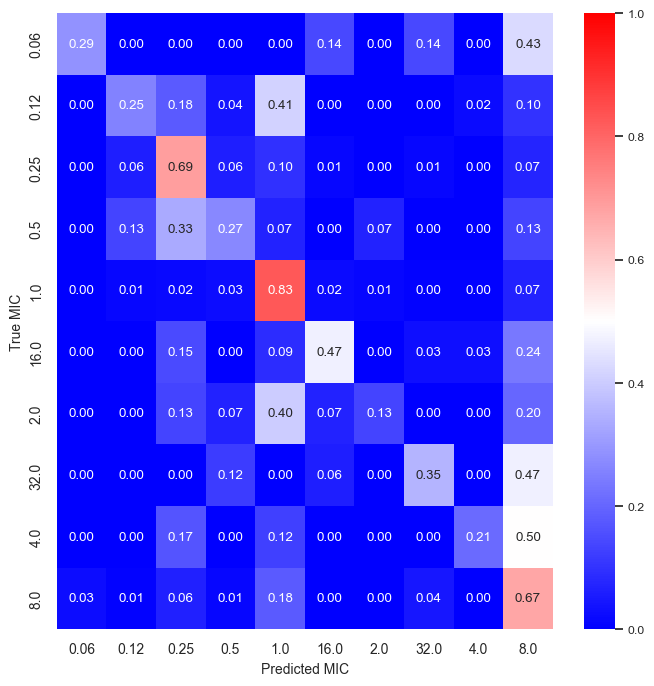

In [16]:
# entrena el modelo con los parámetros óptimos y hace la predicción en los datos de test
best_model.fit(X_train, y_train)
# Predecir etiquetas
y_hat = best_model.predict(X_test)

results_report(y_test, y_hat, le)

## CART

In [17]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'ccp_alpha': [0.1, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005],
    'max_features': ['auto', 'sqrt', 'log2'],
}
# Crear instancia del clasificador
DT = DecisionTreeClassifier()
cv = 5
best_params, best_score = search_params_ordinal(DT, X_train, y_train, param_grid, cv)
print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación:", best_score)

Mejores hiperparámetros: {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_features': 'log2'}
Mejor puntuación: 0.5651955054035355


In [18]:
# Crear una nueva instancia del clasificador ordinal
best_model = DecisionTreeClassifier(ccp_alpha = best_params['ccp_alpha'],
                            criterion = best_params['criterion'],
                            max_features = best_params['max_features'])

n_repeats = 10
mean_mae, mean_rmse, std_mae, std_rmse = ordinal_clas_stat2(best_model, X_train, y_train, rand_state = 42, 
                                                            n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print(f"MAE: {mean_mae:.3f} +/- {std_mae:.3f}")
print(f"RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")

MAE: 1.599 +/- 0.103
RMSE: 2.765 +/- 0.125


MAE:  1.738 
RMSE:  3.011
              precision    recall  f1-score   support

           0       0.09      0.14      0.11         7
           1       0.27      0.39      0.32        51
           2       0.55      0.63      0.59        84
           3       0.27      0.27      0.27        15
           4       0.72      0.70      0.71       221
           5       0.37      0.21      0.26        34
           6       0.00      0.00      0.00        15
           7       0.42      0.29      0.34        17
           8       0.17      0.17      0.17        24
           9       0.62      0.60      0.61       159

    accuracy                           0.55       627
   macro avg       0.35      0.34      0.34       627
weighted avg       0.55      0.55      0.55       627



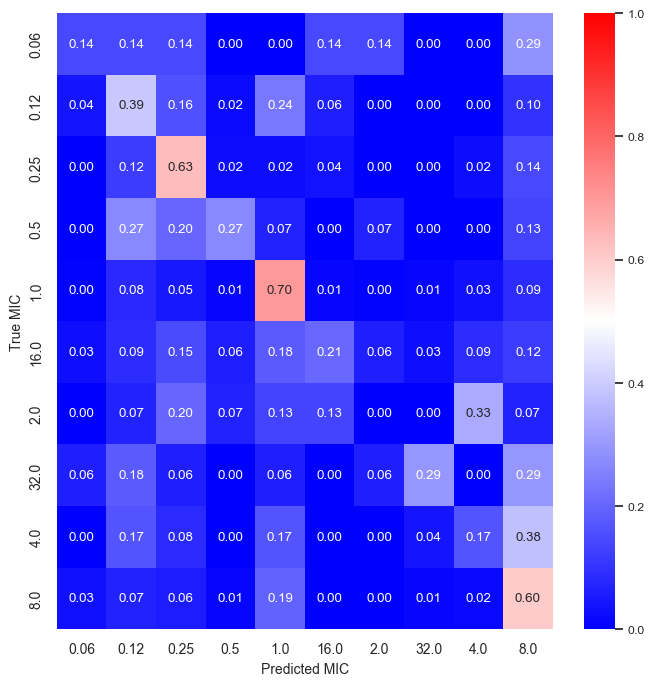

In [19]:
# entrena el modelo con los parámetros óptimos y hace la predicción en los datos de test
best_model.fit(X_train, y_train)
# Predecir etiquetas
y_hat = best_model.predict(X_test)

results_report(y_test, y_hat, le)

## Random Forests

In [21]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'ccp_alpha': [0.1, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005],
    'max_features': ['sqrt', 'log2']
}

# Crear instancia del clasificador
RF = RandomForestClassifier()
cv = 5
best_params, best_score = search_params_ordinal(RF, X_train, y_train, param_grid, cv)
print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación:", best_score)

Mejores hiperparámetros: {'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 500}
Mejor puntuación: 0.6784820796653704


In [22]:
# Crear una nueva instancia del clasificador ordinal
best_model = RandomForestClassifier(n_estimators = best_params['n_estimators'],
                            criterion = best_params['criterion'],
                            class_weight = best_params['class_weight'],
                            ccp_alpha = best_params['ccp_alpha'],
                            max_features = best_params['max_features'])


n_repeats = 10
mean_mae, mean_rmse, std_mae, std_rmse = ordinal_clas_stat2(best_model, X_train, y_train, rand_state = 42, 
                                                            n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print(f"MAE: {mean_mae:.3f} +/- {std_mae:.3f}")
print(f"RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")

MAE: 1.131 +/- 0.074
RMSE: 2.294 +/- 0.105


MAE:  1.206 
RMSE:  2.448
              precision    recall  f1-score   support

           0       0.22      0.29      0.25         7
           1       0.59      0.31      0.41        51
           2       0.60      0.75      0.67        84
           3       0.21      0.27      0.24        15
           4       0.75      0.85      0.80       221
           5       0.70      0.47      0.56        34
           6       0.20      0.13      0.16        15
           7       0.56      0.59      0.57        17
           8       0.50      0.12      0.20        24
           9       0.69      0.69      0.69       159

    accuracy                           0.66       627
   macro avg       0.50      0.45      0.45       627
weighted avg       0.65      0.66      0.64       627



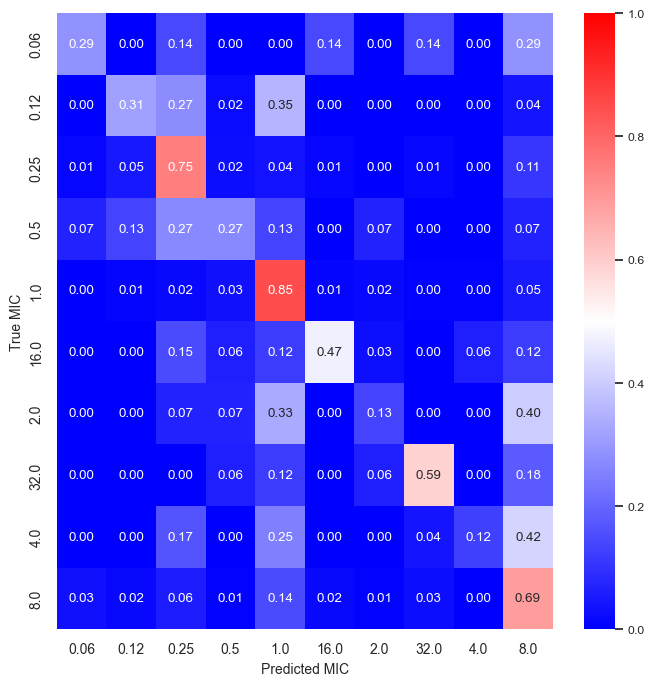

In [23]:
best_model.fit(X_train, y_train)
# Predecir etiquetas
y_hat = best_model.predict(X_test)

results_report(y_test, y_hat, le)

## Red neuronal

In [50]:
from camda_functions import ordinal_encoding_nn, prediction2label_nn, cross_val_metrics_nn

X_train_np = np.array(X_train)
X_test_np = np.array(X_test)

# recodificar la variable de respuesta con un encoding ordinal
n_clas = len(le.classes_)
n_var = X_train_np.shape[1]
y_tr_oc = ordinal_encoding_nn(y_train, n_clas)
y_te_oc = ordinal_encoding_nn(y_test, n_clas)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import activations

X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
n_var = X_train_np.shape[1]
n_clas = len(le.classes_)
# Crear una instancia del modelo
model = Sequential()
#model.add(Dropout(0.2, input_shape = (n_var,)))
#model.add(Dense(80, activation='relu'))
model.add(Dense(80, input_dim=n_var, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))
model.add(Dense(n_clas, activation='softmax'))  

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [51]:
# Cross validation
cv = 5
mae_mean, mae_std, rmse_mean, rmse_std = cross_val_metrics_nn_standard(model, X_train_np, y_train, cv)
# Imprimir los resultados
print(f"MAE: {mae_mean} +/- {mae_std}")
print(f"RMSE: {rmse_mean} +/- {rmse_std}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
MAE: 0.8662539462906855 +/- 0.1414504798296962
RMSE: 2.000748338929261 +/- 0.21380146105462883


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
MAE:  1.153 
RMSE:  2.406
              precision    recall  f1-score   support

           0       0.20      0.29      0.24         7
           1       0.73      0.37      0.49        51
           2       0.64      0.74      0.69        84
           3       0.19      0.27      0.22        15
           4       0.82      0.83      0.82       221
           5       0.81      0.50      0.62        34
           6       0.18      0.13      0.15        15
           7       0.38      0.47      0.42        17
           8       0.75      0.12      0.21        24
           9       0.65      0.79      0.71       159

    accuracy                           0.68       627
   macro avg       0.54      0.45      0.46       627
weighted avg       0.69      0.68      0.67       627



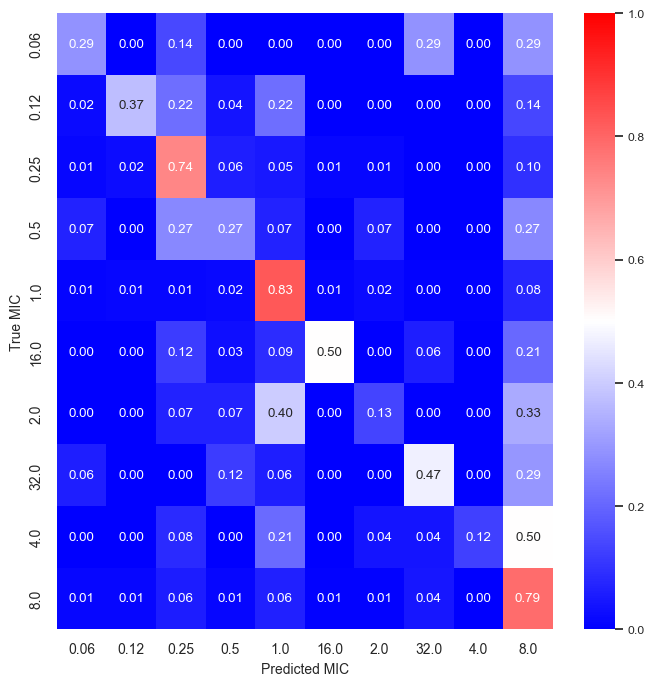

In [52]:
# Train the model
model.fit(X_train_np, y_train, epochs=50, batch_size=16, validation_data=(X_test_np, y_test), verbose=False)
y_hat = np.argmax(model.predict(X_test_np), axis=-1)
results_report(y_test, y_hat, le)